In [58]:
# %load crypto_pred_pract.py
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# load dataset with singling out the rows with desired crypto
df = pd.read_csv(r'C:\Users\Administrator\Desktop\programming\datasets\crypto\crypto-markets.csv')
df = df.loc[df['name'] == 'Bitcoin']

# basic exploration for data organization and possible noise
df.columns

Index(['slug', 'symbol', 'name', 'date', 'ranknow', 'open', 'high', 'low',
       'close', 'volume', 'market', 'close_ratio', 'spread'],
      dtype='object')

In [59]:
df.head(10)

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.0,1.500520e+09,0.5438,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.0,1.491160e+09,0.7813,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.0,1.597780e+09,0.3843,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.0,1.542820e+09,0.2882,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.0,1.292190e+09,0.3881,33.32
5,bitcoin,BTC,Bitcoin,2013-05-03,1,106.25,108.13,79.10,97.75,0.0,1.180070e+09,0.6424,29.03
6,bitcoin,BTC,Bitcoin,2013-05-04,1,98.10,115.00,92.50,112.50,0.0,1.089890e+09,0.8889,22.50
7,bitcoin,BTC,Bitcoin,2013-05-05,1,112.90,118.80,107.14,115.91,0.0,1.254760e+09,0.7521,11.66
8,bitcoin,BTC,Bitcoin,2013-05-06,1,115.98,124.66,106.64,112.30,0.0,1.289470e+09,0.3141,18.02
9,bitcoin,BTC,Bitcoin,2013-05-07,1,112.25,113.44,97.70,111.50,0.0,1.248470e+09,0.8767,15.74


In [60]:
df.isnull().any()

slug           False
symbol         False
name           False
date           False
ranknow        False
open           False
high           False
low            False
close          False
volume         False
market         False
close_ratio    False
spread         False
dtype: bool

In [61]:
# dropping columns that will have little or counterproductive effect on the process
df = df.drop(['symbol', 'slug', 'ranknow', 'spread', 'close_ratio', 'name'], 1)
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'market'], dtype='object')

In [62]:
df.describe()

,open,high,low,close,volume,market
count,1866.000000,1866.000000,1866.000000,1866.000000,1.866000e+03,1.866000e+03
mean,1885.744502,1951.660102,1812.283730,1889.513762,1.171548e+09,3.078214e+10
std,3321.359095,3458.838432,3153.471445,3323.418678,3.023214e+09,5.621236e+10
min,68.500000,74.560000,65.530000,68.430000,0.000000e+00,7.792550e+08
25%,284.857500,291.127500,280.985000,285.310000,1.726688e+07,4.051458e+09
50%,565.950000,576.295000,535.000000,565.975000,4.917735e+07,7.290880e+09
75%,1055.210000,1094.930000,1034.742500,1059.617500,2.448032e+08,1.696472e+10
max,19475.800000,20089.000000,18974.100000,19497.400000,2.384090e+10,3.261410e+11


In [63]:
# setting up date column as the index for time series
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,open,high,low,close,volume,market
date,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,0.0,1.500520e+09
2013-04-29,134.44,147.49,134.00,144.54,0.0,1.491160e+09
2013-04-30,144.00,146.93,134.05,139.00,0.0,1.597780e+09
2013-05-01,139.00,139.89,107.72,116.99,0.0,1.542820e+09
2013-05-02,116.38,125.60,92.28,105.21,0.0,1.292190e+09


In [64]:
# selecting the beginning date of relevant data, adding some features, dropping other
df = df['2017-01-01':]
df['daily_avg'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
df['hilo'] = (df['high'] - df['close']) / df['close'] * 100

# adding rolling average feature, taken from previous 6 entries, filling in NaN
df_rolling_avg = df['close']
df_rolling_avg = df_rolling_avg.rolling(window=6).mean()
df_rolling_avg = df_rolling_avg.rename('rolling_avg', inplace=True)
df = pd.concat([df, df_rolling_avg],1)
df = df.fillna(method='backfill')

# df = df.drop(['slug', 'symbol', 'name', 'ranknow'], 1)

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNetCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from timeit import default_timer as timer

In [66]:
df

,open,high,low,close,volume,market,daily_avg,hilo,rolling_avg
date,,,,,,,,,
2017-01-01,963.66,1003.08,958.70,998.33,1.477750e+08,1.549120e+10,980.9425,0.475795,1022.371667
2017-01-02,998.62,1031.39,996.70,1021.75,2.221850e+08,1.605510e+10,1012.1150,0.943479,1022.371667
2017-01-03,1021.60,1044.08,1021.60,1043.84,1.851680e+08,1.642660e+10,1032.7800,0.022992,1022.371667
2017-01-04,1044.40,1159.42,1044.40,1154.73,3.449460e+08,1.679540e+10,1100.7375,0.406156,1022.371667
2017-01-05,1156.73,1191.10,910.42,1013.38,5.101990e+08,1.860400e+10,1067.9075,17.537350,1022.371667
...,...,...,...,...,...,...,...,...,...
2018-06-02,7536.72,7695.83,7497.26,7643.45,4.939300e+09,1.286450e+11,7593.3150,0.685293,7449.028333
2018-06-03,7632.09,7754.89,7613.04,7720.25,4.851760e+09,1.302880e+11,7680.0675,0.448690,7546.405000
2018-06-04,7722.53,7753.82,7474.04,7514.47,4.993170e+09,1.318470e+11,7616.2150,3.185188,7553.385000


In [67]:
# shifting data to make space for a 3 months worth forecast, splitting for training
df['forecast'] = df['daily_avg'].shift(-90)
X = df.dropna().drop(['forecast'], axis=1)
y = df.dropna()['forecast']

In [68]:
def reg_results_kfold(X, y, regressors):

    result_dict = {}
    cv = KFold(n_splits=5, random_state=42, shuffle=False)

    for name,regressor in regressors:
        
        rmse = []
        mae = []
        r2 = []
               
        for train_index, test_index in cv.split(X):
            X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
            score = regressor.fit(X_train, y_train)
            prediction = score.predict(X_test)
            
            rmse.append(np.sqrt(mean_squared_error(y_test, prediction)))
            mae.append(mean_absolute_error(y_test, prediction))
            r2.append(score.score(X_train, y_train))
        
        if name not in result_dict:
            result_dict[name] = []
            
        result_dict[name].append(np.mean(rmse))
        result_dict[name].append(np.mean(mae))
        result_dict[name].append(np.mean(r2))

    return result_dict

In [69]:
regressors = [['LinearRegression : ', LinearRegression()],
              ['BayesianRidge : ', BayesianRidge()],
              ['ElasticNetCV : ', ElasticNetCV()],
              ['DecisionTreeRegressor :', DecisionTreeRegressor()],
              ['RandomForestRegressor :', RandomForestRegressor()],
              ['ExtraTreesRegressor :', ExtraTreesRegressor()],
              ['GradientBoostingRegressor :', GradientBoostingRegressor()],
              ['XGBRegressor :', XGBRegressor()]]

In [70]:
reg_columns = ['RMSE', 'MAE', 'R2']

regressor_results_kfold = reg_results_kfold(X, y, regressors)
regressor_results_kfold = pd.DataFrame.from_dict(regressor_results_kfold, orient='index')
regressor_results_kfold.columns = reg_columns
regressor_results_kfold

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


,RMSE,MAE,R2
LinearRegression :,4716.403722,3862.629420,0.414363
BayesianRidge :,4633.122919,3894.889775,0.352246
ElasticNetCV :,4396.604167,3734.407583,0.302250
DecisionTreeRegressor :,2565.722478,1952.807688,1.000000
RandomForestRegressor :,2390.665953,1877.050560,0.984593
ExtraTreesRegressor :,2377.441379,1874.334726,1.000000
GradientBoostingRegressor :,2321.219166,1811.306720,0.986356
XGBRegressor :,2439.801586,1892.738945,0.999996


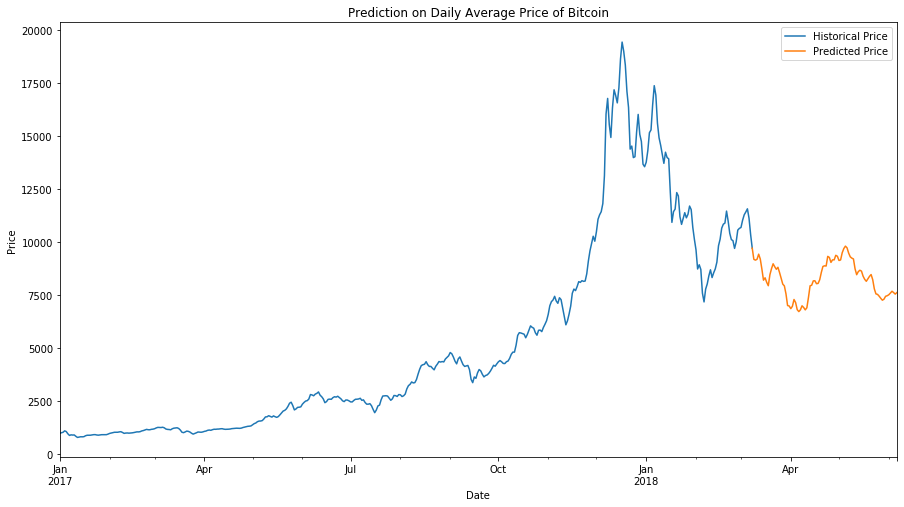

In [71]:
# picking and using the best performing model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# predicting with the best performing model
predict = model.predict(forecast)

# plotting the results into a graph
plt.figure(figsize=(15,8))
(df[:-90]['daily_avg']).plot(label='Historical Price')
(df[-91:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Prediction on Daily Average Price of Bitcoin')
plt.legend()
plt.show()